<a href="https://colab.research.google.com/github/ypeng22/DLFinal/blob/main/DL_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
!pip install plantcv
!pip install c3d

     |████████████████████████████████| 225kB 8.2MB/s 
     |████████████████████████████████| 48.6MB 115kB/s 
     |████████████████████████████████| 706kB 40.6MB/s 
ERROR: distributed 2021.4.1 has requirement dask>=2021.03.0, but you'll have dask 2.12.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: dask-jobqueue 0.7.2 has requirement dask>=2.19, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import c3d
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import os
from plantcv import plantcv as pcv
from scipy import ndimage
import torchvision

In [3]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")


Mounted at /content/gdrive


In [2]:
data_dir = "/content/gdrive/MyDrive/BerkeleyMHAD/"
subjects = ['S01', 'S02', 'S03', 'S04', 'S05','S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12']
actions = ['A01', 'A02', 'A03', 'A04', 'A05','A06', 'A07', 'A08', 'A09', 'A10', 'A11']
reps = ['R01', 'R02', 'R03', 'R04', 'R05']

#LSTM on Skeleton Data

In [3]:
################ Dataloader for Berkeley Mocap Optical Data #################

def c3d2array(loc: str, frame_rate):
    """
    Takes in the file location of the c3d file as a string and returns a 
    numpy array w/ the sensor data
    Array Shape: Num_frames x 43 x 3 
      43 corresponds to the number of nodes on the person
      3 corresponds to spatial coordinates of the nodes
    """
    point_series = []
    reader = c3d.Reader(open(loc, 'rb'))
    for i, points, analog in reader.read_frames():     
        if i % frame_rate == 0: ## Set Frame Rate to approximately 22 Hz instead of 480 Hz
            point_series.append(points[:, 0:3])
    point_series = np.array(point_series)
    return point_series

class BerkeleyMocapOpticalDataset(Dataset):
    """Berkeley Mocap Optical Dataset."""

    def __init__(self, root_dir, train, frame_rate, transform=None):
        """
        Args:
            root_dir (string): Directory with all the data
            train (string): has to be one of "train", "test", or "val"
            frame_rate (integer): In Hz 
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        if train == 'train':
            self.list_c3d = [file for file in os.listdir(root_dir) if (os.path.isfile(os.path.join(root_dir, file)) and file[-1] != 't' and int(file[5:7]) < 9) ] #list of all the c3d file names for the first 8 subjects
        elif train == 'test':
            self.list_c3d = [file for file in os.listdir(root_dir) if (os.path.isfile(os.path.join(root_dir, file)) and file[-1] != 't' and int(file[5:7]) > 8 and int(file[5:7]) < 12) ] #list of all the c3d file names for the subjects 9, 10, 11
        else:
            self.list_c3d = [file for file in os.listdir(root_dir) if (os.path.isfile(os.path.join(root_dir, file)) and file[-1] != 't' and int(file[5:7]) == 12) ] #list of all the c3d file names for the subject 12
        self.frame_rate = frame_rate
        self.transform = transform
        for idx, item in enumerate(self.list_c3d): 
            item_loc = os.path.join(self.root_dir, item)
            self.list_c3d[idx] = (c3d2array(item_loc, self.frame_rate), item)

    def __len__(self):
        return len(self.list_c3d)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.list_c3d[idx][0]
        c3d_file_location = os.path.join(self.root_dir,
                                self.list_c3d[idx][1])
        label_location = c3d_file_location.find('_a')
        if label_location == -1: # FUCK T-POSE
            label = 12
        else: 
            label = int(c3d_file_location[label_location+2:label_location+4])
        if self.transform:
            sample = self.transform(sample)
        # Flatten Samples 
        sample = torch.transpose(sample, 0, 1)
        sample = torch.flatten(sample, 1, 2)
        sample = torch.unsqueeze(sample, 0)
        sample = sample.float()
        # I think labels should go from 0 through 11 since we are using argmax later for loss/accuracy
        return sample, label - 1


############### Compute Mean and SD across the dataset #############
## If you wish to uncomment the code below and rerun it, you might have to comment out the three lines which cflatten the sample in the class above
'''transform = None
root_dir = data_dir + 'Mocap/OpticalData'
frame_rate = 1

dataloader = BerkeleyMocapOpticalDataset(root_dir, "train", 1)
x_list = []
y_list = []
z_list = []

for sample,_ in dataloader:
  x_list.append(np.ndarray.flatten(sample[:,:,0]))
  y_list.append(np.ndarray.flatten(sample[:,:,1]))
  z_list.append(np.ndarray.flatten(sample[:,:,2]))

x_list = np.concatenate(np.array(x_list))
y_list = np.concatenate(np.array(y_list))
z_list = np.concatenate(np.array(z_list))
x_mean = np.mean(x_list)
x_sd = np.std(x_list)
y_mean = np.mean(y_list)
y_sd = np.std(y_list)
z_mean = np.mean(z_list)
z_sd = np.std(z_list)
print([x_mean, y_mean, z_mean, x_sd, y_sd, z_sd])'''

############### Define a transform with mean, std, and tensor ############
## So we don't need to rerun for the mean and standard deviations every time
x_mean, x_sd, y_mean, y_sd, z_mean, z_sd = -455.09898495222086, 245.84348947768748, 148.47916727630624, 183.09031602408763, 814.4396506806088, 538.2824468734605
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((x_mean, y_mean, z_mean), (x_sd, y_sd, z_sd)),
])


############# Final Dataloaders ####################
root_dir = data_dir + 'Mocap/OpticalData'
frame_rate = 22
val_dataloader = BerkeleyMocapOpticalDataset(root_dir, "val", frame_rate, transform=transform)
train_dataloader = BerkeleyMocapOpticalDataset(root_dir, "train", frame_rate, transform=transform)
test_dataloader = BerkeleyMocapOpticalDataset(root_dir, "test", frame_rate, transform=transform)



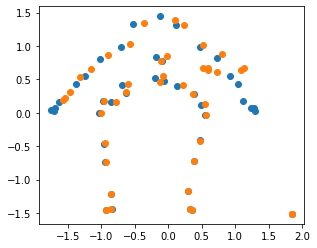

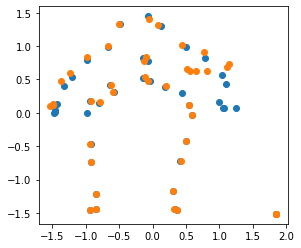

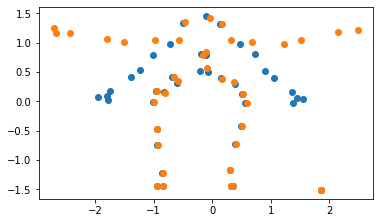

In [113]:
############ Test The Dataloader ######################

## This code is for case in which the sample is NOT flattened
'''i = 3
for sample,_ in train_dataloader:
  if i == 0:
    break
  i = i - 1
  frame = 1
  xs, ys, zs = sample[0, frame, :], sample[1, frame, :], sample[2, frame, :]
  plt.figure()
  plt.scatter(xs, zs)
  plt.axis('scaled')
  xs, ys, zs = sample[0, frame+10, :], sample[1, frame+10, :], sample[2, frame+10, :]
  plt.scatter(xs, zs)
  plt.axis('scaled')'''

## This code is for the case in which the sample IS flattened
i = 3
for sample,_ in train_dataloader:
  if i == 0:
    break
  i = i - 1
  frame = 1
  xs, ys, zs = sample[0, frame, 0:43], sample[0, frame, 43:86], sample[0, frame, 86:]
  plt.figure()
  plt.scatter(xs, zs)
  plt.axis('scaled')
  xs, ys, zs = sample[0, frame+10, 0:43], sample[0, frame+10, 43:86], sample[0, frame+10, 86:]
  plt.scatter(xs, zs)
  plt.axis('scaled')

In [4]:
class skeletonLSTM(nn.Module):
    def __init__(self, classes):
        super(skeletonLSTM, self).__init__()
        self.n_hidden = 100
        self.n_layers = 2
        self.l_lstm = torch.nn.LSTM(input_size = 129, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, classes)
        self.relu = nn.ReLU()
    def forward(self, x):
        #intialize lstm hidden state
        hidden_state = torch.zeros(self.n_layers, 1, self.n_hidden).cuda()
        cell_state = torch.zeros(self.n_layers, 1, self.n_hidden).cuda()
        self.hidden = (hidden_state, cell_state)      
        #print(x.shape)
        lstm_out, _ = self.l_lstm(x, self.hidden) #lstm_out shape is batch_size, seq len, hidden state
        lstm_out = lstm_out[:,-1,:]
        lstm_out = self.relu(self.fc1(lstm_out.squeeze()))
        lstm_out = self.fc2(lstm_out)
        return lstm_out
    

In [12]:
class skeletonLSTMunrolled(nn.Module):
    def __init__(self, classes):
        super(skeletonLSTMunrolled, self).__init__()
        self.n_hidden = 100
        self.n_layers = 1
        self.l_lstm = torch.nn.LSTM(input_size = 129, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, classes)
        self.relu = nn.ReLU()
    def forward(self, x):
        #intialize lstm hidden state
        hidden_state = torch.zeros(self.n_layers, 1, self.n_hidden).cuda()
        cell_state = torch.zeros(self.n_layers, 1, self.n_hidden).cuda()
        self.hidden = (hidden_state, cell_state)      
        for frame in range(x.shape[1]):
            x_frame = x[:, frame, :].unsqueeze(1)
            x_frame, self.hidden = self.l_lstm(x_frame, self.hidden)#lstm_out shape is batch_size, seq len, hidden state
        lstm_out = x_frame[:,-1,:]
        lstm_out = self.relu(self.fc1(lstm_out.squeeze()))
        lstm_out = self.fc2(lstm_out)
        return lstm_out


In [ ]:
 num_epochs = 50
 num_classes = 11
 model = skeletonLSTM(num_classes)
 model.cuda()
 loss_func = nn.CrossEntropyLoss()
 optimizer = torch.optim.Adam(model.parameters())
 
 train_loss_vec = []
 val_loss_vec = []
 for epoch in range(num_epochs):
    train_loss_for_epoch = []
    val_loss_for_epoch = []
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    for inputs, labels in train_dataloader:
          inputs = inputs.cuda()
          model.train()
          if labels not in tuple(range(num_classes)): #FUCK T-POSE
              continue
          labels = torch.Tensor([labels]).cuda()
          predictions = model(inputs).unsqueeze(0)
          loss = loss_func(predictions, labels.long())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss_for_epoch.append(loss.item())

    train_loss_vec.append(sum(train_loss_for_epoch) / len(train_loss_for_epoch))
    for inputs, labels in val_dataloader:
          inputs = inputs.cuda()
          model.eval()
          if labels not in tuple(range(num_classes)): #FUCK T-POSE
              continue
          labels = torch.Tensor([labels]).cuda()
          predictions = model(inputs).unsqueeze(0)
          loss = loss_func(predictions, labels.long())
          val_loss_for_epoch.append(loss.item())
          if val_loss_for_epoch[-1] == min(val_loss_for_epoch):
              torch.save(model, '/content/gdrive/MyDrive/best_model.pth')
    val_loss_vec.append(sum(val_loss_for_epoch) / len(val_loss_for_epoch) )
    print("The training loss for Epoch " + str(epoch + 1) + " is " + str(train_loss_vec[-1]))
    print("The validation loss for Epoch " + str(epoch + 1) + " is " + str(val_loss_vec[-1]))


In [13]:
num_epochs = 50
num_classes = 11
model = skeletonLSTMunrolled(num_classes)
model.cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
 
train_loss_vec = []
val_loss_vec = []
for epoch in range(num_epochs):
    train_loss_for_epoch = []
    val_loss_for_epoch = []
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    for inputs, labels in train_dataloader:
          inputs = inputs.cuda()
          model.train()
          if labels not in tuple(range(num_classes)): #FUCK T-POSE
              continue
          labels = torch.Tensor([labels]).cuda()
          predictions = model(inputs).unsqueeze(0)
          loss = loss_func(predictions, labels.long())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss_for_epoch.append(loss.item())

    train_loss_vec.append(sum(train_loss_for_epoch) / len(train_loss_for_epoch))
    for inputs, labels in val_dataloader:
          inputs = inputs.cuda()
          model.eval()
          if labels not in tuple(range(num_classes)): #FUCK T-POSE
              continue
          labels = torch.Tensor([labels]).cuda()
          predictions = model(inputs).unsqueeze(0)
          loss = loss_func(predictions, labels.long())
          val_loss_for_epoch.append(loss.item())
          if val_loss_for_epoch[-1] == min(val_loss_for_epoch):
              torch.save(model, '/content/gdrive/MyDrive/best_model_unrolled.pth')
    val_loss_vec.append(sum(val_loss_for_epoch) / len(val_loss_for_epoch) )
    print("The training loss for Epoch " + str(epoch + 1) + " is " + str(train_loss_vec[-1]))
    print("The validation loss for Epoch " + str(epoch + 1) + " is " + str(val_loss_vec[-1]))



EPOCH 1 of 20

The training loss for Epoch 1 is 1.1312232255935668
The validation loss for Epoch 1 is 1.0949738025665283

EPOCH 2 of 20

The training loss for Epoch 2 is 1.098706163962682
The validation loss for Epoch 2 is 1.0979700167973836

EPOCH 3 of 20

The training loss for Epoch 3 is 1.0909621740380924
The validation loss for Epoch 3 is 1.1655609289805093

EPOCH 4 of 20

The training loss for Epoch 4 is 1.0470146780212721
The validation loss for Epoch 4 is 1.0773457725842794

EPOCH 5 of 20

The training loss for Epoch 5 is 1.0108056947588921
The validation loss for Epoch 5 is 0.9888019998868306

EPOCH 6 of 20

The training loss for Epoch 6 is 0.8072237047056358
The validation loss for Epoch 6 is 0.5607468619942665

EPOCH 7 of 20

The training loss for Epoch 7 is 0.6030974195261175
The validation loss for Epoch 7 is 0.5149517325063546

EPOCH 8 of 20

The training loss for Epoch 8 is 0.4630229561356828
The validation loss for Epoch 8 is 0.39489944571008284

EPOCH 9 of 20

The trai

In [28]:
def train_val_test(model, num_classes=11):
    ################ Model Accuracy On Train Dataset Post Training #################
    accurates = 0
    samples = 0 
    for input, label in train_dataloader:
        if label not in tuple(range(num_classes)): #FUCK T-POSE
            continue
        input = input.cuda()
        out = model(input)
        if torch.argmax(out).item() == label:
          accurates += 1
        samples += 1
    accuracy = accurates / samples
    print('The model accuracy on the train dataset after training is ' + str(accuracy))

    ################ Model Accuracy On Validation Dataset Post Training #################
    accurates = 0
    samples = 0 
    for input, label in val_dataloader:
        if label not in tuple(range(num_classes)): #FUCK T-POSE
            continue
        input = input.cuda()
        out = model(input)
        if torch.argmax(out).item() == label:
          accurates += 1
        samples += 1
    accuracy = accurates / samples
    print('The model accuracy on the validation dataset after training is ' + str(accuracy))

    # Accuracies are 98/96/82
    ################ Model Accuracy On Test Dataset Post Training #################
    accurates = 0
    samples = 0 
    for input, label in test_dataloader:
        if label not in tuple(range(num_classes)): #FUCK T-POSE
            continue
        input = input.cuda()
        out = model(input)
        if torch.argmax(out).item() == label:
          accurates += 1
        samples += 1
    accuracy = accurates / samples
    print('The model accuracy on the testing dataset after training is ' + str(accuracy))


model = torch.load('/content/gdrive/MyDrive/best_model.pth')
# 45ish epoch model https://drive.google.com/file/d/1SzOCnZ5kWuuEQ5GpYz9TAqYbjwYfP5kZ/view?usp=sharing
    ################ Model Accuracy On Train Dataset Post Training #################
train_val_test(model, 11)    

The model accuracy on the train dataset after training is 1.0
The model accuracy on the validation dataset after training is 0.9818181818181818
The model accuracy on the testing dataset after training is 0.8


In [29]:
model = torch.load('/content/gdrive/MyDrive/best_model_unrolled.pth')
# 45ish epoch model https://drive.google.com/file/d/1SzOCnZ5kWuuEQ5GpYz9TAqYbjwYfP5kZ/view?usp=sharing
    ################ Model Accuracy On Train Dataset Post Training #################
train_val_test(model, 3)    

The model accuracy on the train dataset after training is 1.0
The model accuracy on the validation dataset after training is 0.9333333333333333
The model accuracy on the testing dataset after training is 0.6666666666666666


In [ ]:
plt.plot(train_loss_vec)
plt.plot(val_loss_vec)
plt.xlabel('Epochs'), plt.ylabel('Cross Entropy Loss')

NameError: ignored

In [12]:

model = torch.load('/content/gdrive/MyDrive/best_model.pth')

In [8]:

class GradientAttack():
        
        """
        
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y, model, num_iter=1, alpha=0.01):
            """
            Generates an adversary using the gradient sign method
            given an input feature, its associated label, and the model
            x: feature vector
            y: label associated with the feature vector
            model: the model used to classify x
            num_iter: number of iterations to perturb sample, for num_iter=1, uses fast gradient sign method
            alpha: the size of the perturbation for iterative gradient sign method         
            """
            y = torch.Tensor([y]).cuda()
            x = x.cuda()
            model.train()
            x_adv = x
            for iteration in range(num_iter):
                x_adv = x_adv.cuda()
                x_adv = Variable(x_adv, requires_grad=True)
                # Step 1: Calculate the Loss and then calculate the
                # gradient of the Loss w.r.t the image
                loss_adv = self.loss(model(x_adv).unsqueeze(0), y.long())
                loss_adv.backward(retain_graph=True) 
                with torch.no_grad():
                    # Step 2: Add the gradient (or its sign for each pixel),
                    # multiplied by a small step size, to the original image                   
                    # You might need to clamp the modified image to 
                    # make sure the values of each pixel are between [0,1]    
                    if num_iter > 1:                                                           
                        x_temp = x_adv + torch.sign(x_adv.grad) * alpha
                        # Clamp the attack to be within such that the maximum difference is epsilon
                        x_adv = x + torch.clamp(x_temp - x, -self.epsilon, self.epsilon)
                    else:
                        x_adv = x + torch.sign(x_adv.grad) * self.epsilon
            return x_adv

In [60]:
def printgradnorm(self, grad_input, grad_output):

    print('Inside ' + self.__class__.__name__ + ' backward')
    print('Inside class:' + self.__class__.__name__)
    print('')
    print('grad_input: ', type(grad_input))
    print('grad_input[0]: ', type(grad_input[0]))
    print('grad_output: ', type(grad_output))
    print('grad_output[0]: ', type(grad_output[0]))
    print('')
    print('grad_input size:', grad_input[0].size())
    print('grad_output size:', grad_output[0].size())
    print('grad_input norm:', grad_input[0].norm())

class PMPAttack():
        
        """
        
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y, model, num_iter=1, alpha=0.01):
            """
            Generates an adversary using the gradient sign method
            given an input feature, its associated label, and the model
            x: feature vector
            y: label associated with the feature vector
            model: the model used to classify x
            num_iter: number of iterations to perturb sample, for num_iter=1, uses fast gradient sign method
            alpha: the size of the perturbation for iterative gradient sign method         
            """
            y = torch.Tensor([y]).cuda()
            x = x.cuda()
            model.train()
            x_adv = x
            ## Step 1
            ## for debugging purposes, hidden state jacobian should be 100 x 100

            x_adv = x_adv.cuda()
            x_adv = Variable(x_adv, requires_grad=True)
            loss_adv = self.loss(model(x_adv).unsqueeze(0), y.long())
            loss_adv.backward(retain_graph=True) 
            for k in range(x_adv.shape[1]):
                print(model.l_lstm.weight_hh_l0)
            for iteration in range(num_iter):
                x_adv = x_adv.cuda()
                x_adv = Variable(x_adv, requires_grad=True)
                # Step 1: Calculate the Loss and then calculate the
                # gradient of the Loss w.r.t the image
                loss_adv = self.loss(model(x_adv).unsqueeze(0), y.long())
                loss_adv.backward(retain_graph=True) 
                with torch.no_grad():
                    # Step 2: Add the gradient (or its sign for each pixel),
                    # multiplied by a small step size, to the original image                   
                    # You might need to clamp the modified image to 
                    # make sure the values of each pixel are between [0,1]    
                    if num_iter > 1:                                                           
                        x_temp = x_adv + torch.sign(x_adv.grad) * alpha
                        # Clamp the attack to be within such that the maximum difference is epsilon
                        x_adv = x + torch.clamp(x_temp - x, -self.epsilon, self.epsilon)
                    else:
                        x_adv = x + torch.sign(x_adv.grad) * self.epsilon
            return x_adv

In [62]:
loss = nn.CrossEntropyLoss()
adv_attack = PMPAttack(loss, 0.1)

model = torch.load('/content/gdrive/MyDrive/best_model.pth')
print(model)
for input, label in train_dataloader:
    if label == 11: 
        continue
    input_adv = adv_attack.forward(input, label, model, num_iter=1, alpha=.01)
    model.eval()
    out = model(input_adv)

skeletonLSTM(
  (l_lstm): LSTM(129, 100, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=11, bias=True)
  (relu): ReLU()
)
Parameter containing:
tensor([[-0.0504, -0.0220,  0.0409,  ..., -0.0248, -0.0078,  0.1165],
        [-0.0903,  0.0112,  0.0518,  ...,  0.0324, -0.0639, -0.1527],
        [-0.2247,  0.0874,  0.1159,  ...,  0.2170, -0.0356, -0.1312],
        ...,
        [-0.0308, -0.1572,  0.0246,  ..., -0.0934,  0.0238, -0.0540],
        [ 0.2093, -0.1201,  0.0281,  ...,  0.0153, -0.0664, -0.1955],
        [-0.0698, -0.0937,  0.0607,  ...,  0.0512,  0.0884,  0.0592]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0504, -0.0220,  0.0409,  ..., -0.0248, -0.0078,  0.1165],
        [-0.0903,  0.0112,  0.0518,  ...,  0.0324, -0.0639, -0.1527],
        [-0.2247,  0.0874,  0.1159,  ...,  0.2170, -0.0356, -0.1312],
        ...,
        [-0.0308, -0.1572,  0.0246,  ..., 

KeyboardInterrupt: ignored

In [ ]:

loss = nn.CrossEntropyLoss()
adv_attack = GradientAttack(loss, 0.1)

################ Model Accuracy On Train Dataset Against Attacks#################
accurates = 0
for input, label in train_dataloader:
    if label == 11: 
        continue
    input_adv = adv_attack.forward(input, label, model, num_iter=1)
    model.eval()
    out = model(input_adv)
    if torch.argmax(out).item() == label:
        accurates += 1

accuracy = accurates / len(train_dataloader)
print('The model accuracy on the train dataset after training is ' + str(accuracy))

################ Model Accuracy On Validation Dataset Against Attacks #################
accurates = 0
for input, label in val_dataloader:
    if label == 11: 
        continue
    input_adv = adv_attack.forward(input, label, model, num_iter=1)
    model.eval()
    out = model(input_adv)
    if torch.argmax(out).item() == label:
        accurates += 1

accuracy = accurates / len(val_dataloader)
print('The model accuracy on the validation dataset after training is ' + str(accuracy))

################ Model Accuracy On Test Dataset Against Attacks#################    
accurates = 0
for input, label in test_dataloader:
    if label == 11: 
        continue
    input_adv = adv_attack.forward(input, label, model, num_iter=1)
    model.eval()
    out = model(input_adv)
    if torch.argmax(out).item() == label:
        accurates += 1

accuracy = accurates / len(test_dataloader)
print('The model accuracy on the testing dataset after training is ' + str(accuracy))

The model accuracy on the train dataset after training is 0.8568232662192393
The model accuracy on the validation dataset after training is 0.7678571428571429
The model accuracy on the testing dataset after training is 0.6190476190476191


In [ ]:
loss = nn.CrossEntropyLoss()
adv_attack = GradientAttack(loss, 0.1)

################ Model Accuracy On Train Dataset Against Attacks#################
accurates = 0
for input, label in train_dataloader:
    if label == 11: 
      continue
    input_adv = adv_attack.forward(input, label, model, num_iter=100, alpha=0.005)
    model.eval()
    out = model(input_adv)
    if torch.argmax(out).item() == label:
      accurates += 1

accuracy = accurates / len(train_dataloader)
print('The model accuracy on the train dataset after training is ' + str(accuracy))

################ Model Accuracy On Validation Dataset Against Attacks#################
accurates = 0
for input, label in val_dataloader:
    if label == 11: 
          continue
    input_adv = adv_attack.forward(input, label, model, num_iter=100, alpha=0.005)
    model.eval()
    out = model(input_adv)
    if torch.argmax(out).item() == label:
      accurates += 1

accuracy = accurates / len(val_dataloader)
print('The model accuracy on the validation dataset after training is ' + str(accuracy))


################ Model Accuracy On Test Dataset Against Attacks#################
accurates = 0
for input, label in test_dataloader:
    if label == 11: 
          continue
    input_adv = adv_attack.forward(input, label, model, num_iter=100, alpha=0.005)
    model.eval()
    out = model(input_adv)
    if torch.argmax(out).item() == label:
      accurates += 1

accuracy = accurates / len(test_dataloader)
print('The model accuracy on the testing dataset after training is ' + str(accuracy))

The model accuracy on the train dataset after training is 0.6666666666666666
The model accuracy on the validation dataset after training is 0.6607142857142857
The model accuracy on the testing dataset after training is 0.5416666666666666


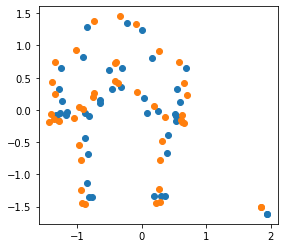

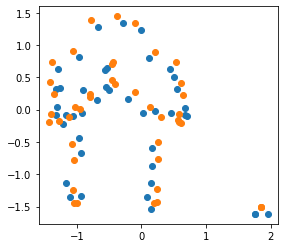

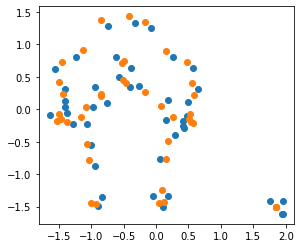

In [ ]:
## This code is for the case in which the sample IS flattened
i = 3
for input, label in train_dataloader:
  if label == 11: 
      continue
  orig_input = input
  sample = adv_attack.forward(input, label, model, num_iter=200, alpha=0.0025).cpu().detach()
  if i == 0:
    break
  i = i - 1
  frame = 1
  xs, ys, zs = sample[0, frame, 0:43], sample[0, frame, 43:86], sample[0, frame, 86:]
  plt.figure()
  plt.scatter(xs, zs)
  plt.axis('scaled')
  xs, ys, zs = orig_input[0, frame, 0:43], orig_input[0, frame, 43:86], orig_input[0, frame, 86:]
  plt.scatter(xs, zs)
  plt.axis('scaled')

Probably should use 20 or so epochs based on these results